# Exploratory Data Analysis of NBER Papers

This notebook performs an initial exploratory data analysis (EDA) on the NBER working papers dataset stored in our SQLite database. The goal is to understand the basic characteristics of the data, such as:

- The distribution of papers over time.
- The typical length of paper abstracts.
- The most common words found in the abstracts.


In [11]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data from SQLite Database

In [2]:

# Define paths
PROJECT_ROOT = Path().resolve().parent
DB_PATH = PROJECT_ROOT / "data" / "03_primary" / "nber_papers.db"
TABLE_NAME = "papers"

# Connect to the database and load data
try:
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", conn)
    conn.close()
    print(f"Successfully loaded {len(df)} records.")
except Exception as e:
    print(f"Error loading data: {e}")

# Display basic info and the first few rows
print("--- DataFrame Info ---")
df.info()
print("\n--- DataFrame Head ---")
print(df.head())

Successfully loaded 49749 records.
--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49749 entries, 0 to 49748
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paper       49749 non-null  object
 1   author      49092 non-null  object
 2   title       49744 non-null  object
 3   issue_date  49749 non-null  object
 4   doi         1707 non-null   object
 5   abstract    36304 non-null  object
dtypes: object(6)
memory usage: 2.3+ MB

--- DataFrame Head ---
    paper                                             author  \
0  w31403  Rodrigo Oliveira, Alei Santos, Edson R. Severnini   
1  w31390                    M. Scott Taylor, Fruzsina Mayer   
2  w27853  Steven N. Kaplan, Morten Sorensen, Anastasia A...   
3  w27851   Tania Babina, Asaf Bernstein, Filippo Mezzanotti   
4  w27910  Kyle Handley, Nuno Limão, Rodney D. Ludema, Zh...   

                                               title           is

## 2. Distribution of Papers Over Time

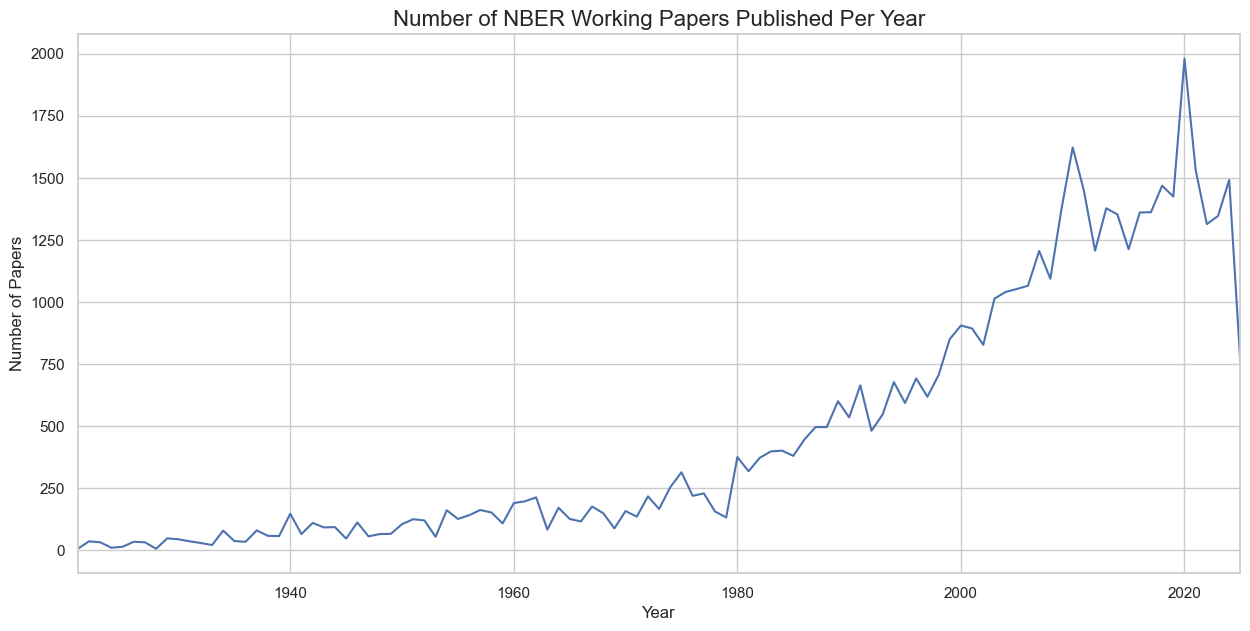

In [6]:
# Convert issue_date to datetime and extract the year
df['issue_date'] = pd.to_datetime(df['issue_date'])
df['year'] = df['issue_date'].dt.year

# Plot the number of papers published per year
plt.figure(figsize=(15, 7))
papers_per_year = df['year'].value_counts().sort_index()
sns.lineplot(x=papers_per_year.index, y=papers_per_year.values)
plt.title('Number of NBER Working Papers Published Per Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xlim(papers_per_year.index.min(), papers_per_year.index.max())
plt.show()


# ## 3. Text Analysis: Abstract Length
#
# Let's analyze the length of the abstracts to understand their general verbosity.

## 3. Text Analysis: Abstract Length

Let's analyze the length of the abstracts to understand their general verbosity.

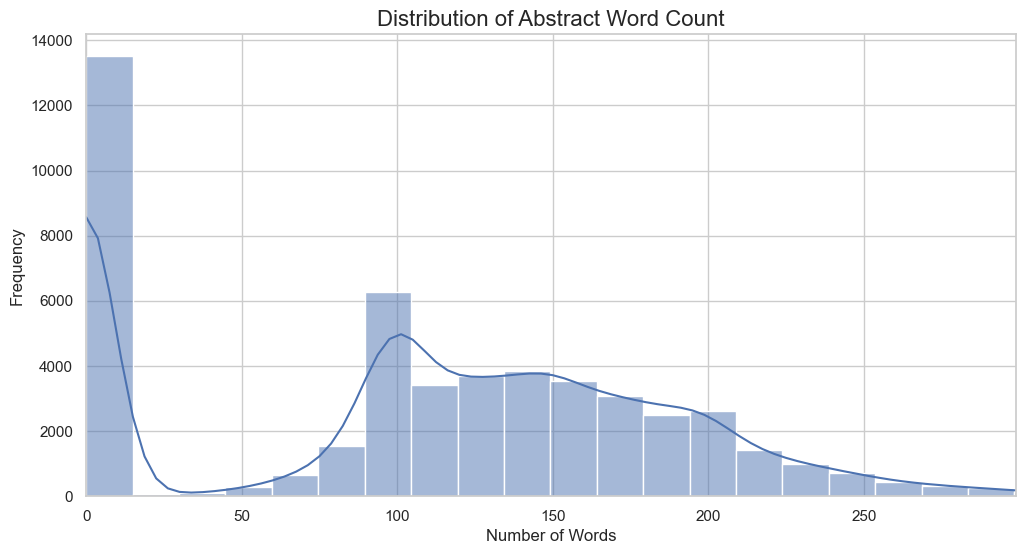


--- Abstract Word Count Statistics ---
count    49749.000000
mean       109.509015
std         81.508531
min          0.000000
25%          0.000000
50%        116.000000
75%        167.000000
max        746.000000
Name: abstract_word_count, dtype: float64


In [5]:
# Calculate the number of words in each abstract
# Fill NaN values with an empty string first
df['abstract_word_count'] = df['abstract'].fillna('').apply(lambda x: len(x.split()))

# Plot the distribution of abstract word counts
plt.figure(figsize=(12, 6))
sns.histplot(df['abstract_word_count'], bins=50, kde=True)
plt.title('Distribution of Abstract Word Count', fontsize=16)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, df['abstract_word_count'].quantile(0.99)) # Exclude extreme outliers for better visualization
plt.show()

print("\n--- Abstract Word Count Statistics ---")
print(df['abstract_word_count'].describe())

## 4. Text Analysis: Most Common Words

Finally, let's identify the most frequently used words in the paper abstracts. We will use `CountVectorizer` and remove common English stop words to get meaningful results.

/var/folders/xp/90b2vmmj0cg7rv097x887f6m0000gn/T/ipykernel_77654/4141053703.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_words, palette='viridis')


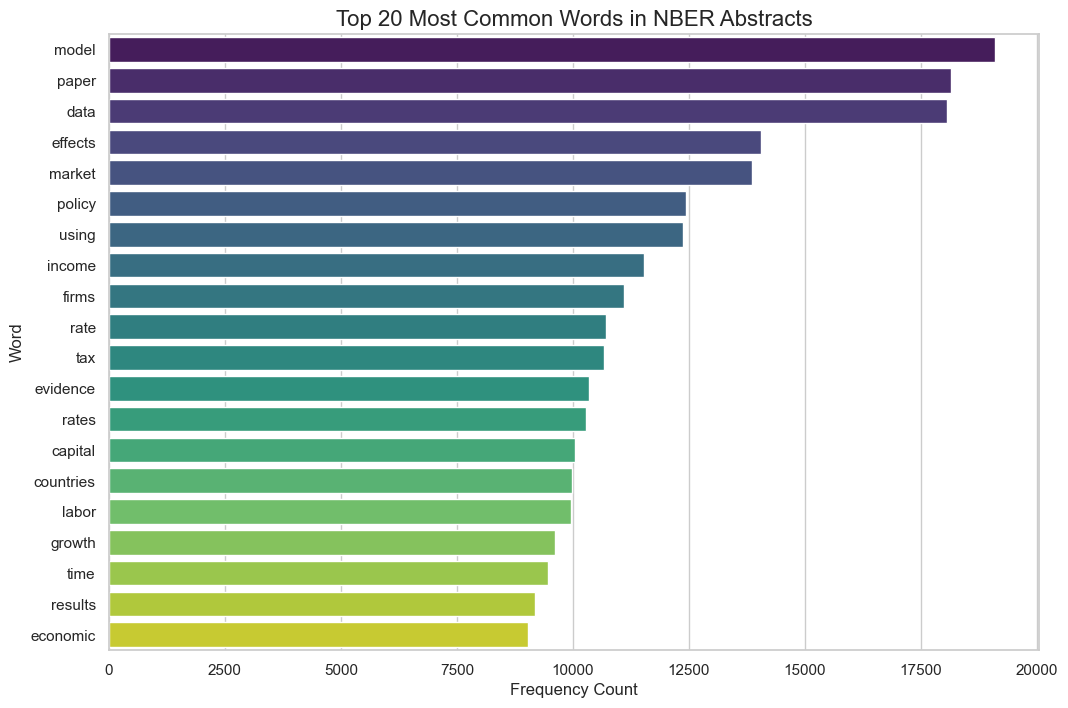

In [4]:
# Use CountVectorizer to get word counts
# We limit to the top 1000 features and remove English stop words
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['abstract'].fillna(''))

# Sum the word counts across all documents
word_counts = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'count': X.toarray().sum(axis=0)
})

# Get the top 20 most common words
top_words = word_counts.sort_values(by='count', ascending=False).head(20)

# Plot the top 20 words
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=top_words, palette='viridis')
plt.title('Top 20 Most Common Words in NBER Abstracts', fontsize=16)
plt.xlabel('Frequency Count')
plt.ylabel('Word')
plt.show()



## 5. TF-IDF Analysis: Characteristic Terms per Year
TF-IDF (Term Frequency-Inverse Document Frequency) helps us find words that are important to a specific document relative to the entire corpus. Here, we'll treat all abstracts from a single year as one "document" and find the term that is most characteristic of that year.


In [12]:
# Aggregate all abstracts for each year into a single string
yearly_text = df.groupby('year')['abstract'].apply(lambda x: ' '.join(x.fillna(''))).reset_index()
yearly_text = yearly_text[yearly_text['year'] >= 1970] # Focus on more recent years for clarity

# Use TfidfVectorizer to find the most important word for each year
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(yearly_text['abstract'])
feature_names = tfidf_vectorizer.get_feature_names_out()

def get_top_n_terms(row_vector, n=5):
    """Get the top N terms from a TF-IDF vector row."""
    # Sort the indices of the vector by their score and take the top N
    top_indices = np.argsort(row_vector.toarray()).flatten()[-n:]
    # Reverse to get highest scores first
    top_indices = top_indices[::-1]
    return [feature_names[i] for i in top_indices]

# Apply the function to each year's TF-IDF vector
yearly_text['top_5_terms'] = [get_top_n_terms(row) for row in tfidf_matrix]

# Create a clean DataFrame for display
top_terms_df = yearly_text[['year', 'top_5_terms']]

print("\n--- Top 5 TF-IDF Terms per Year ---")
# Display the last 20 years for brevity. Pandas' default printing is clean.
print(top_terms_df.tail(20).to_string())


--- Top 5 TF-IDF Terms per Year ---
     year                                 top_5_terms
85   2006     [model, paper, data, market, countries]
86   2007       [model, paper, data, effects, market]
87   2008       [model, data, paper, market, effects]
88   2009     [model, paper, data, market, countries]
89   2010        [model, paper, data, policy, market]
90   2011  [model, data, paper, financial, countries]
91   2012    [model, data, paper, effects, financial]
92   2013       [model, data, market, paper, effects]
93   2014       [model, data, effects, market, paper]
94   2015        [data, model, effects, using, paper]
95   2016        [model, data, effects, using, paper]
96   2017       [data, model, using, effects, market]
97   2018        [data, model, effects, using, labor]
98   2019       [data, model, using, effects, policy]
99   2020     [covid, covid 19, data, model, effects]
100  2021     [data, covid, model, effects, covid 19]
101  2022     [data, model, effects, using, p

## 6. Topic Modeling with LDA

Let's use Latent Dirichlet Allocation (LDA) to identify abstract "topics" across the entire dataset. A topic is a collection of words that tend to appear together.


In [9]:
# We need raw counts for LDA, so we use CountVectorizer again.
# We'll also filter for words that appear in at least a few documents.
lda_vectorizer = CountVectorizer(max_df=0.9, min_df=50, stop_words='english', max_features=1000)
lda_counts = lda_vectorizer.fit_transform(df['abstract'].fillna(''))

# Define and fit the LDA model
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(lda_counts)

# Helper function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("\n--- Latent Topics Discovered by LDA ---")
display_topics(lda_model, lda_vectorizer.get_feature_names_out(), 10)


--- Latent Topics Discovered by LDA ---
Topic 1:
labor | workers | wage | employment | wages | job | market | unemployment | earnings | work
Topic 2:
health | insurance | care | effects | children | data | using | use | effect | increase
Topic 3:
rate | rates | inflation | exchange | monetary | real | school | policy | students | long
Topic 4:
countries | trade | country | international | foreign | capital | paper | financial | domestic | world
Topic 5:
risk | market | financial | firms | debt | returns | stock | investment | credit | banks
Topic 6:
income | social | retirement | households | wealth | consumption | age | security | household | data
Topic 7:
data | research | evidence | economic | effects | information | public | quality | paper | new
Topic 8:
growth | firms | productivity | firm | data | industry | production | level | technology | using
Topic 9:
model | price | models | policy | prices | paper | equilibrium | optimal | market | data
Topic 10:
tax | income | governmen

## 7. Word Cloud Visualization
A word cloud is a classic way to visualize text frequency. We'll generate one for the entire corpus.


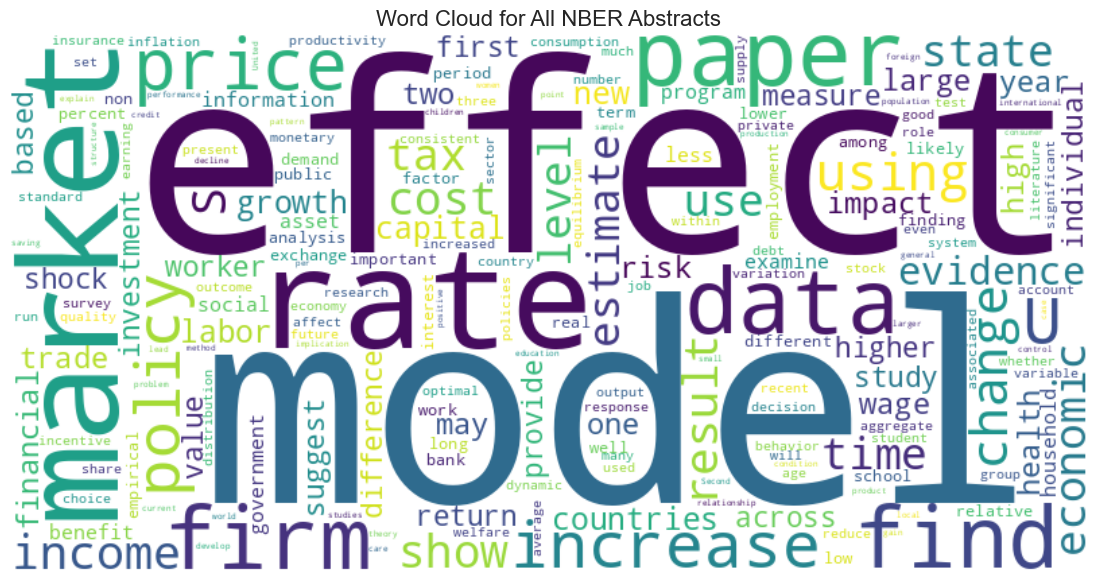

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Combine all abstracts into one giant string
full_corpus_text = ' '.join(df['abstract'].fillna(''))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                     collocations=False, stopwords=STOPWORDS).generate(full_corpus_text)
# Display the generated image:
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for All NBER Abstracts", fontsize=16)
plt.show()